## Import libraries

In [ ]:
# Load in Datasets native format
from datasets import Dataset, DatasetDict

from google.colab import drive
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd



import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("NLTK resources 'stopwords' and 'punkt' downloaded, and necessary libraries imported.")


NLTK resources 'stopwords' and 'punkt' downloaded, and necessary libraries imported.


## Load dataset

In [ ]:
# Load and explore the workplaceMA
micro_agg_url = "https://huggingface.co/spaces/khanak27/microaggressionsdetector/resolve/main/micro_agg.csv"

workplaceMA = pd.read_csv(micro_agg_url, encoding='latin-1')
print(f"Successfully loaded with latin-1 encoding")

print(f"Dataset shape: {workplaceMA.shape}")
print(f"Columns: {workplaceMA.columns.tolist()}")
print(f"\nFirst few rows:")
display(workplaceMA.head(10))

print(f"\nData types:")
print(workplaceMA.dtypes)

print(f"\nMissing values:")
print(workplaceMA.isnull().sum())

print(f"\nLabel distribution:")
print(workplaceMA['label'].value_counts().sort_index())

# Check for any text preprocessing needed
print(f"\nSample texts:")
for i in range(3):
    print(f"{i+1}. Label {workplaceMA.iloc[i]['label']}: {workplaceMA.iloc[i]['speech']}")

Successfully loaded with latin-1 encoding
Dataset shape: (171, 2)
Columns: ['speech', 'label']

First few rows:


,speech,label
0,You're very articulate for someone like you.,1
1,Where are you really from?,1
2,You're not like other girls.,1
3,You must be good at math since you're Asian.,1
4,You're too pretty to be a software engineer.,1
5,Are you sure you want to lead this project?,1
6,You don't look gay.,1
7,You are a credit to your race.,1
8,"That's a strange name, is it foreign?",1
9,Do you even understand this topic?,1



Data types:
speech    object
label      int64
dtype: object

Missing values:
speech    0
label     0
dtype: int64

Label distribution:
label
0    87
1    84
Name: count, dtype: int64

Sample texts:
1. Label 1: You're very articulate for someone like you.
2. Label 1: Where are you really from?
3. Label 1: You're not like other girls.


Perform an exploratory data analysis (EDA) on the `workplaceMA` dataset, which includes inspecting its schema, displaying sample data, analyzing the distribution of microaggression labels, and calculating and visualizing the distribution of text lengths. Based on the EDA, outline a strategy for tokenization and vectorization, and propose how to split the dataset into training, validation, and test sets for subsequent modeling. Finally, summarize the key findings from the EDA and the proposed data preparation steps.

## Understand Dataset Schema and Sample Data


In [ ]:
# Print the dataset structure
print(workplaceMA)

                                           speech  label
0    You're very articulate for someone like you.      1
1                      Where are you really from?      1
2                    You're not like other girls.      1
3    You must be good at math since you're Asian.      1
4    You're too pretty to be a software engineer.      1
..                                            ...    ...
166    IÕll check in again by the end of the day.      0
167    Please go ahead and take the lead on this.      0
168       YouÕve handled the updates efficiently.      0
169   LetÕs review the roadmap together tomorrow.      0
170        This approach sounds reasonable to me.      0

[171 rows x 2 columns]


In [ ]:
# Print dataset samples
samples = workplaceMA[0:5]
for i in range(len(samples['speech'])):
    print(f"Text: {samples['speech'][i]}")
    print(f"Label: {samples['label'][i]}\n")

Text: You're very articulate for someone like you.
Label: 1

Text: Where are you really from?
Label: 1

Text: You're not like other girls.
Label: 1

Text: You must be good at math since you're Asian.
Label: 1

Text: You're too pretty to be a software engineer.
Label: 1



## Analyze Label Distribution


In [ ]:
# Print label distribution
print("Label distribution in training set:")
print(Counter(workplaceMA['label']))


Label distribution in training set:
Counter({0: 87, 1: 84})


## Analyze Text Lengths

Calculate and visualize the distribution of text lengths (e.g., number of characters) in the 'text' column for each dataset split.


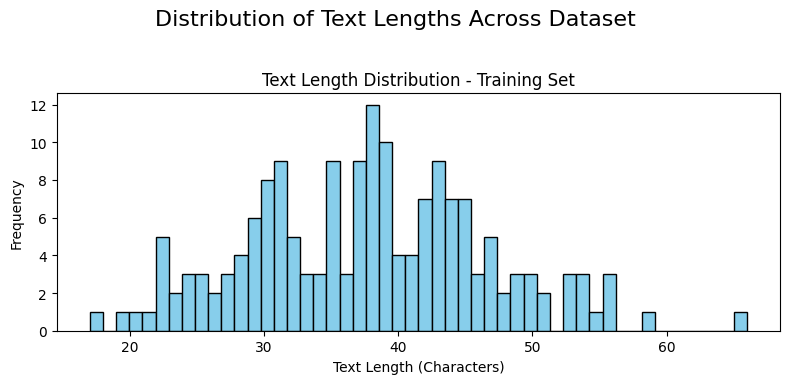

In [ ]:
# Calculate text lengths for each split
text_lengths = [len(text) for text in workplaceMA['speech']]


# Create a figure with subplots
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
fig.suptitle('Distribution of Text Lengths Across Dataset', fontsize=16)

# Plot histogram for evaluation set
axes.hist(text_lengths, bins=50, color='skyblue', edgecolor='black')
axes.set_title('Text Length Distribution - Training Set')
axes.set_xlabel('Text Length (Characters)')
axes.set_ylabel('Frequency')


plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlapping titles
plt.show()

## Analyze Top N-grams per Label

Extract and analyze the most frequent unigrams (single words) and bigrams (two-word phrases) for each microaggression label (0, 1, and 2). Visualize the top N-grams using bar charts for each label.


In [ ]:
# Get English stop words
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words and non-alphabetic tokens
    cleaned_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return cleaned_tokens

print("Preprocessing function 'preprocess_text' created successfully.")

Preprocessing function 'preprocess_text' created successfully.


In [ ]:
# Process samples from workplaceMA
# Initialize texts_by_label with existing labels in workplaceMA
unique_labels = sorted(workplaceMA['label'].unique())
texts_by_label = {label: [] for label in unique_labels}

for index, row in workplaceMA.iterrows():
    text = row['speech']
    label = row['label']
    if label in texts_by_label: # Ensure label exists in dictionary keys
        texts_by_label[label].append(text)

print(f"Texts separated by label:")
for label in sorted(texts_by_label.keys()):
    print(f"  {len(texts_by_label[label])} for label {label}")

Texts separated by label:
  87 for label 0
  84 for label 1


In [ ]:
# Calculate unigrams and bigrams
unigram_counts_by_label = {}
bigram_counts_by_label = {}

for label, texts in texts_by_label.items():
    all_tokens = []
    all_bigrams = []
    for text in texts:
        cleaned_tokens = preprocess_text(text)
        all_tokens.extend(cleaned_tokens)
        # Generate bigrams, handling cases with less than 2 tokens
        if len(cleaned_tokens) >= 2:
            all_bigrams.extend(list(ngrams(cleaned_tokens, 2)))

    unigram_counts_by_label[label] = Counter(all_tokens)
    bigram_counts_by_label[label] = Counter(all_bigrams)

print("Unigram and bigram counts calculated for each label.")

Unigram and bigram counts calculated for each label.


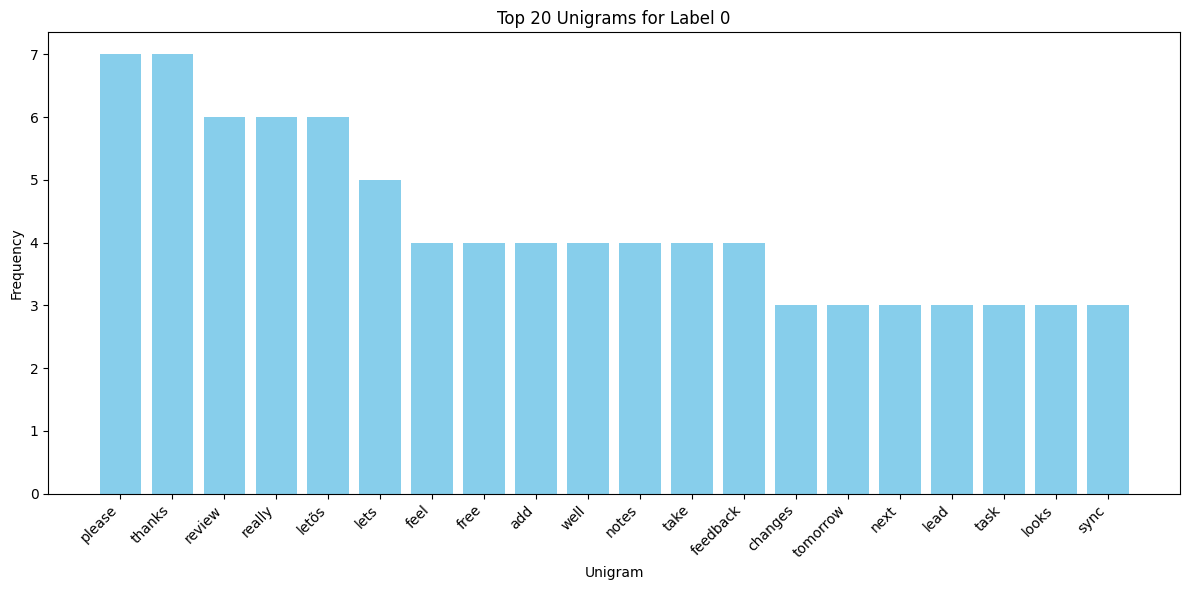

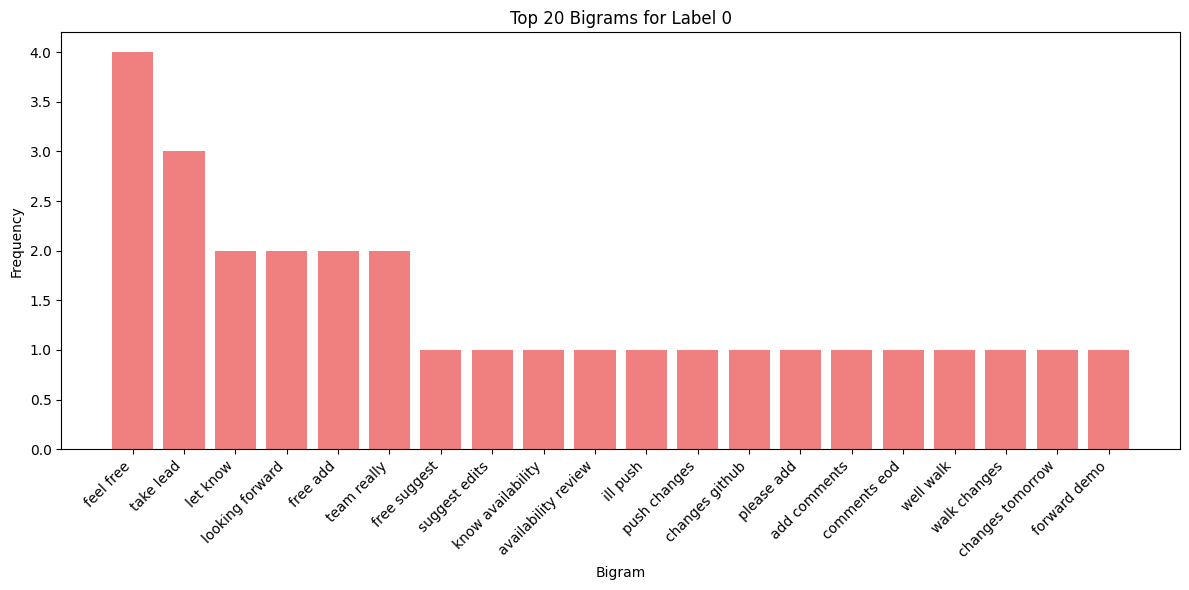

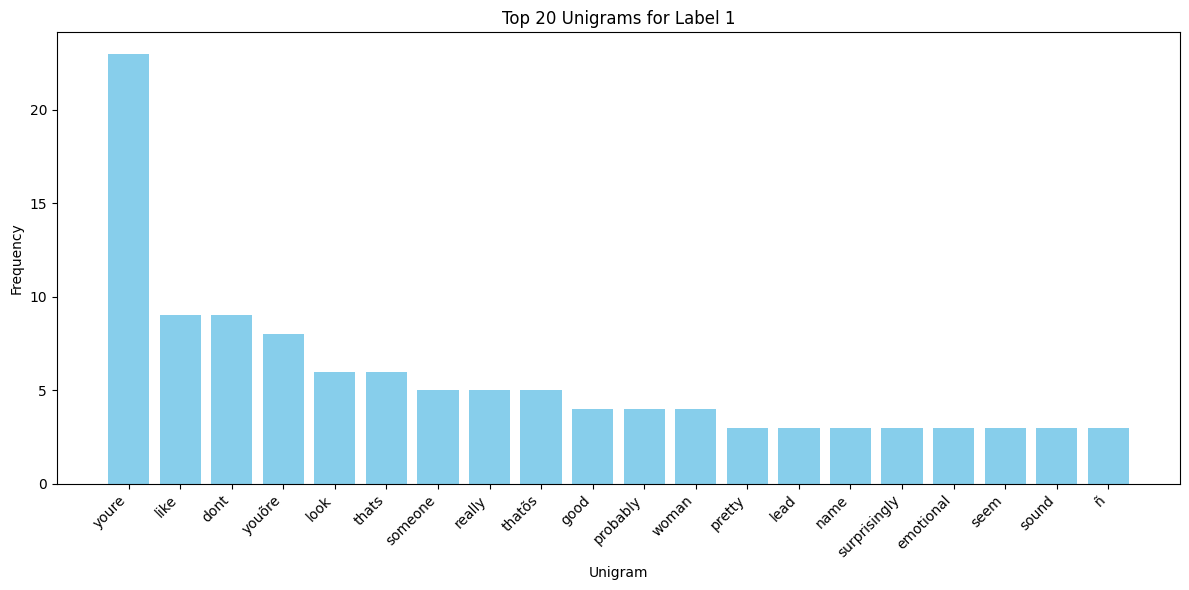

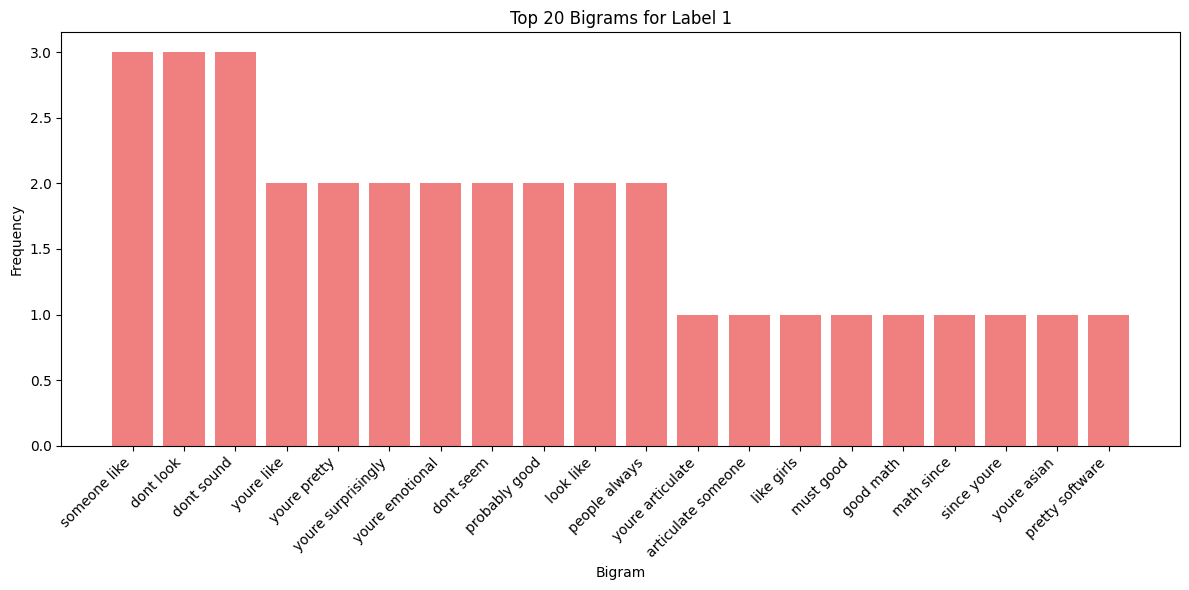

Top 20 unigrams and bigrams visualized for each label.


In [ ]:
# top 20 most frequent unigrams and bigrams for each label
for label in sorted(unigram_counts_by_label.keys()):
    # Get top 20 unigrams
    top_unigrams = unigram_counts_by_label[label].most_common(20)
    words_uni = [word for word, count in top_unigrams]
    counts_uni = [count for word, count in top_unigrams]

    # Plotting top 20 unigrams
    plt.figure(figsize=(12, 6))
    plt.bar(words_uni, counts_uni, color='skyblue')
    plt.xlabel('Unigram')
    plt.ylabel('Frequency')
    plt.title(f'Top 20 Unigrams for Label {label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Get top 20 bigrams
    top_bigrams = bigram_counts_by_label[label].most_common(20)
    words_bi = [' '.join(word) for word, count in top_bigrams]
    counts_bi = [count for word, count in top_bigrams]

    # Plotting top 20 bigrams
    plt.figure(figsize=(12, 6))
    plt.bar(words_bi, counts_bi, color='lightcoral')
    plt.xlabel('Bigram')
    plt.ylabel('Frequency')
    plt.title(f'Top 20 Bigrams for Label {label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

print("Top 20 unigrams and bigrams visualized for each label.")

## Compare Keyword Frequencies Across Labels

Perform a comparative analysis of keyword (unigram and bigram) frequencies across microaggression labels (0, 1, and 2) to identify terms significantly more prevalent in one label than others.


In [ ]:
# Comparative analysis
total_unigrams_by_label = {label: sum(counts.values()) for label, counts in unigram_counts_by_label.items()}
total_bigrams_by_label = {label: sum(counts.values()) for label, counts in bigram_counts_by_label.items()}

print("Total Unigrams per Label:", total_unigrams_by_label)
print("Total Bigrams per Label:", total_bigrams_by_label)

Total Unigrams per Label: {np.int64(0): 344, np.int64(1): 295}
Total Bigrams per Label: {np.int64(0): 257, np.int64(1): 211}


In [ ]:
# Print comparative analysis
for label_to_analyze in sorted(unigram_counts_by_label.keys()):
    print(f"\n--- Comparative Analysis for Top Unigrams in Label {label_to_analyze} ---")
    top_unigrams = unigram_counts_by_label[label_to_analyze].most_common(20)

    data = []
    for unigram, _ in top_unigrams:
        row = {'Unigram': unigram}
        for current_label in sorted(unigram_counts_by_label.keys()):
            # Absolute count
            row[f'Count_L{current_label}'] = unigram_counts_by_label[current_label][unigram]
            # Normalized frequency
            freq = unigram_counts_by_label[current_label][unigram] / total_unigrams_by_label[current_label] if total_unigrams_by_label[current_label] > 0 else 0
            row[f'Freq_L{current_label}'] = f'{freq:.4f}' # Format to 4 decimal places
        data.append(row)

    df_unigrams = pd.DataFrame(data)
    print(df_unigrams.to_string(index=False))


for label_to_analyze in sorted(bigram_counts_by_label.keys()):
    print(f"\n--- Comparative Analysis for Top Bigrams in Label {label_to_analyze} ---")
    top_bigrams = bigram_counts_by_label[label_to_analyze].most_common(20)

    data = []
    for bigram, _ in top_bigrams:
        row = {'Bigram': ' '.join(bigram)}
        for current_label in sorted(bigram_counts_by_label.keys()):
            # Absolute count
            row[f'Count_L{current_label}'] = bigram_counts_by_label[current_label][bigram]
            # Normalized frequency
            freq = bigram_counts_by_label[current_label][bigram] / total_bigrams_by_label[current_label] if total_bigrams_by_label[current_label] > 0 else 0
            row[f'Freq_L{current_label}'] = f'{freq:.4f}' # Format to 4 decimal places
        data.append(row)

    df_bigrams = pd.DataFrame(data)
    print(df_bigrams.to_string(index=False))


--- Comparative Analysis for Top Unigrams in Label 0 ---
 Unigram  Count_L0 Freq_L0  Count_L1 Freq_L1
  please         7  0.0203         0  0.0000
  thanks         7  0.0203         0  0.0000
  review         6  0.0174         0  0.0000
  really         6  0.0174         5  0.0169
   letõs         6  0.0174         0  0.0000
    lets         5  0.0145         0  0.0000
    feel         4  0.0116         0  0.0000
    free         4  0.0116         0  0.0000
     add         4  0.0116         0  0.0000
    well         4  0.0116         1  0.0034
   notes         4  0.0116         1  0.0034
    take         4  0.0116         1  0.0034
feedback         4  0.0116         0  0.0000
 changes         3  0.0087         0  0.0000
tomorrow         3  0.0087         0  0.0000
    next         3  0.0087         0  0.0000
    lead         3  0.0087         3  0.0102
    task         3  0.0087         0  0.0000
   looks         3  0.0087         0  0.0000
    sync         3  0.0087         0  0.00

Exploratory Data Analysis - Microaggressions Dataset
Text length statistics:
  Character length - Min: 17, Max: 66, Mean: 37.7
  Word count - Min: 3, Max: 13, Mean: 6.7


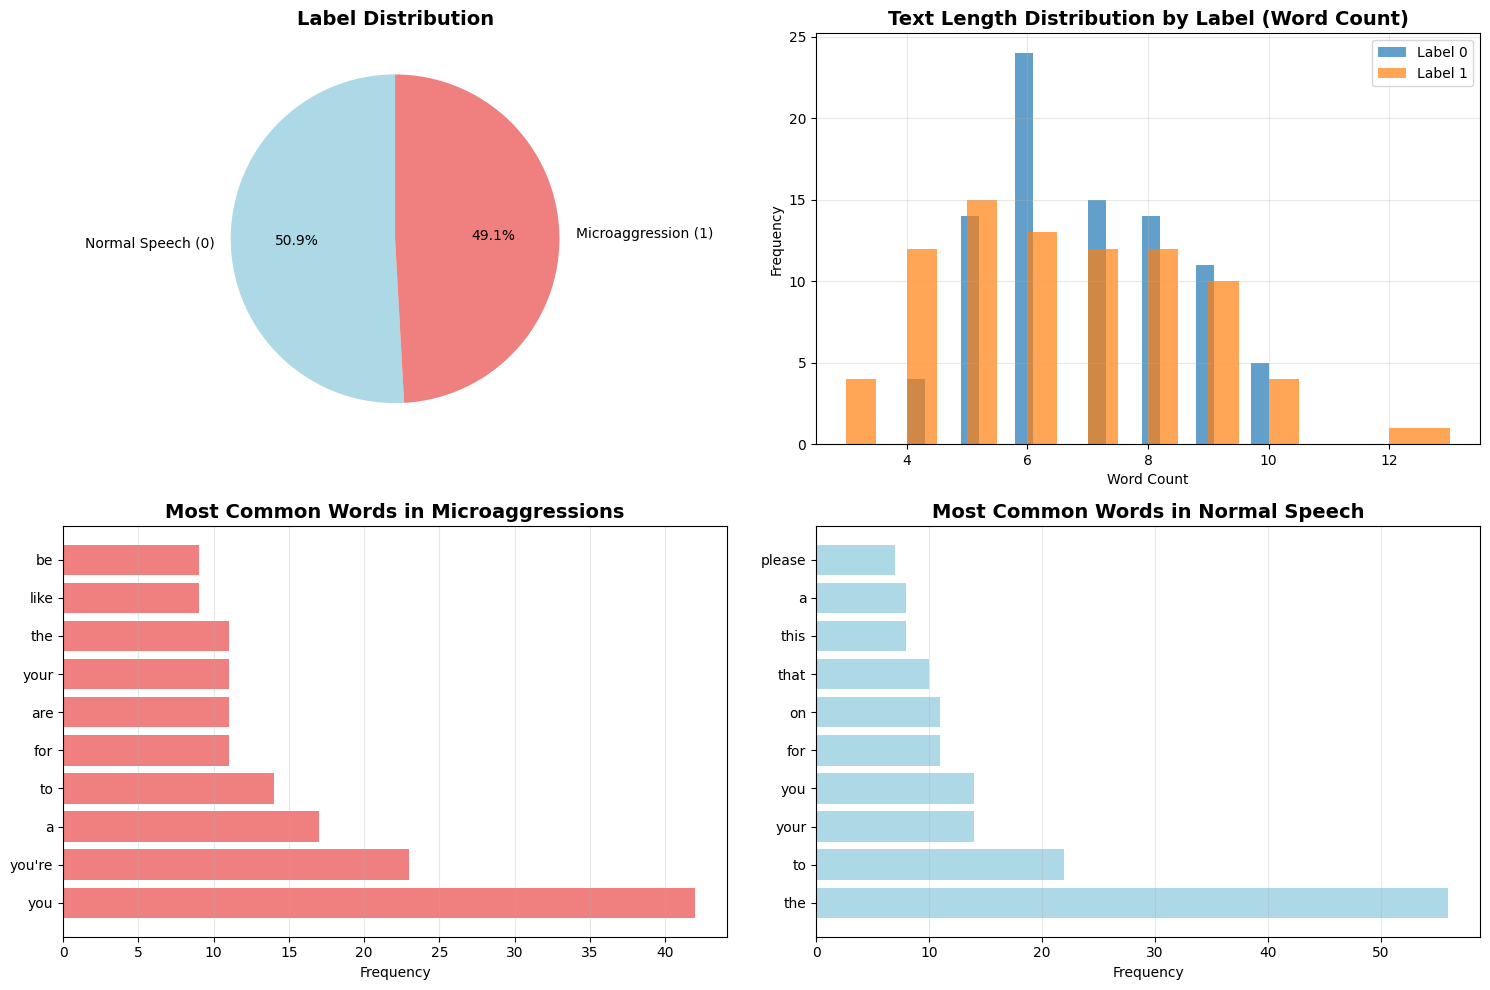

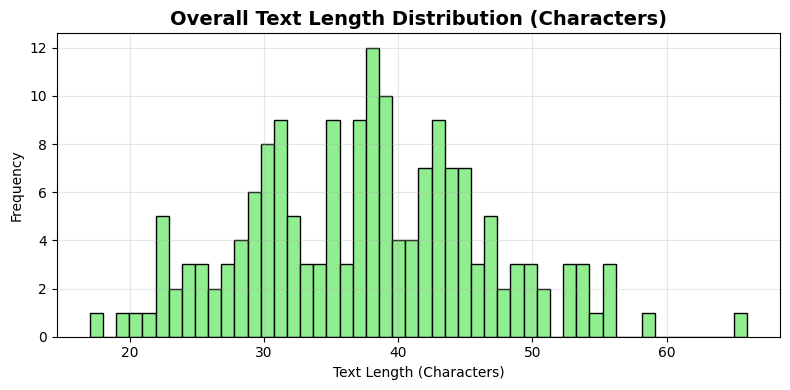


Examples of Microaggressions (Label 1):
1. You're very articulate for someone like you.
2. Where are you really from?
3. You're not like other girls.
4. You must be good at math since you're Asian.
5. You're too pretty to be a software engineer.

Examples of Normal Speech (Label 0):
1. Feel free to suggest any edits.
2. Let me know your availability for review.
3. I'll push the changes to GitHub.
4. Please add your comments by EOD.
5. We'll walk through the changes tomorrow.


In [ ]:
# EDA for microaggressions dataset
print("="*60)
print("Exploratory Data Analysis - Microaggressions Dataset")
print("="*60)

# Text length analysis
df_micro['text_length'] = df_micro['speech'].str.len()
df_micro['word_count'] = df_micro['speech'].str.split().str.len()

print(f"Text length statistics:")
print(f"  Character length - Min: {df_micro['text_length'].min()}, Max: {df_micro['text_length'].max()}, Mean: {df_micro['text_length'].mean():.1f}")
print(f"  Word count - Min: {df_micro['word_count'].min()}, Max: {df_micro['word_count'].max()}, Mean: {df_micro['word_count'].mean():.1f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Label distribution
label_counts = df_micro['label'].value_counts()
axes[0, 0].pie(label_counts.values, labels=['Normal Speech (0)', 'Microaggression (1)'],
               autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
axes[0, 0].set_title('Label Distribution', fontsize=14, fontweight='bold')

# 2. Text length distribution by label (word count)
for label in [0, 1]:
    subset = df_micro[df_micro['label'] == label]
    axes[0, 1].hist(subset['word_count'], alpha=0.7, label=f'Label {label}', bins=20)
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Text Length Distribution by Label (Word Count)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Most common words in microaggressions
micro_texts = df_micro[df_micro['label'] == 1]['speech'].str.lower()
all_micro_words = ' '.join(micro_texts).split()
micro_word_freq = Counter(all_micro_words)
common_micro_words = dict(micro_word_freq.most_common(10))

axes[1, 0].barh(list(common_micro_words.keys()), list(common_micro_words.values()), color='lightcoral')
axes[1, 0].set_xlabel('Frequency')
axes[1, 0].set_title('Most Common Words in Microaggressions', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Most common words in normal speech
normal_texts = df_micro[df_micro['label'] == 0]['speech'].str.lower()
all_normal_words = ' '.join(normal_texts).split()
normal_word_freq = Counter(all_normal_words)
common_normal_words = dict(normal_word_freq.most_common(10))

axes[1, 1].barh(list(common_normal_words.keys()), list(common_normal_words.values()), color='lightblue')
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_title('Most Common Words in Normal Speech', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Add the overall character length distribution histogram
plt.figure(figsize=(8, 4))
plt.hist(df_micro['text_length'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Overall Text Length Distribution (Characters)', fontsize=14, fontweight='bold')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show some examples
print(f"\nExamples of Microaggressions (Label 1):")
micro_examples = df_micro[df_micro['label'] == 1]['speech'].head(5)
for i, text in enumerate(micro_examples, 1):
    print(f"{i}. {text}")

print(f"\nExamples of Normal Speech (Label 0):")
normal_examples = df_micro[df_micro['label'] == 0]['speech'].head(5)
for i, text in enumerate(normal_examples, 1):
    print(f"{i}. {text}")